In [30]:
import torch

print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
torch.cuda.empty_cache()


AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

# Data Analysis

In [5]:
import json
from collections import defaultdict
from itertools import combinations

with open("updated_missouri_v3.json", "r") as file:  
    data = json.load(file)

categories = {category["id"]: category["name"] for category in data.get("categories", [])}
annotations = data.get("annotations", [])

category_counts = defaultdict(int)
for annotation in annotations:
    category_counts[annotation.get("category_id")] += 1

print("Category Breakdown:")
for category_id, category_name in categories.items():
    count = category_counts.get(category_id, 0)
    print(f"{category_id} {category_name}    {count}")

# number of objects per image
image_annotation_counts = defaultdict(int)
for annotation in annotations:
    image_annotation_counts[annotation["image_id"]] += 1

print(f"\nAverage objects per image: {sum(image_annotation_counts.values()) / len(image_annotation_counts):.2f}")
print(f"Images with no objects: {len([count for count in image_annotation_counts.values() if count == 0])}")

# checking invalid category ids
invalid_annotations = [ann for ann in annotations if ann["category_id"] not in categories]
print(f"Invalid annotations: {len(invalid_annotations)}")

# co-occurrence analysis
image_category_sets = defaultdict(set)
co_occurrence_counts = defaultdict(int)
co_occurrence_image_ids = defaultdict(set)

for annotation in annotations:
    image_id = annotation["image_id"]
    category_id = annotation["category_id"]
    image_category_sets[image_id].add(categories[category_id])

# Calculate co-occurrence patterns
for image_id, category_set in image_category_sets.items():
    for pair in combinations(sorted(category_set), 2):
        co_occurrence_counts[pair] += 1
        co_occurrence_image_ids[pair].add(image_id)

# co-occurrence counts
print("\nCategory Co-Occurrences:")
for pair, count in sorted(co_occurrence_counts.items(), key=lambda item: item[1], reverse=True):
    image_ids = list(co_occurrence_image_ids[pair])
    print(f"Categories: {pair}, Co-Occurrence Count: {count}, Image IDs: {image_ids}")

# number of images
unique_image_ids = set(annotation["image_id"] for annotation in annotations)
total_images = len(unique_image_ids)
print(f"\nTotal number of unique images: {total_images}")


Category Breakdown:
2 red_deer    2798
3 roe_deer    1252
5 red_squirrel    618
8 wild_boar    1864
9 white_tailed_deer    2185
13 red_fox    496
14 common_opossum    911
20 bird_spec    777

Average objects per image: 1.00
Images with no objects: 0
Invalid annotations: 0

Category Co-Occurrences:

Total number of unique images: 10892


# Data Preprocessing

### delete some images from categories or all of the category

In [228]:
import json
import os
from random import sample

with open("updated_missouri_v2.json", "r") as file: 
    data = json.load(file)

annotations = data.get("annotations", [])
images = data.get("images", [])
categories = data.get("categories", [])

def delete_images(category_id, num_to_delete=None):
    global categories
    # all image ids that have the specified category_id
    image_ids_to_delete = set()
    for annotation in annotations:
        if annotation["category_id"] == category_id:
            image_ids_to_delete.add(annotation["image_id"])

    if num_to_delete is not None:
        if len(image_ids_to_delete) < num_to_delete:
            raise ValueError("Not enough images with the specified category to delete the requested number.")
        image_ids_to_delete = set(sample(list(image_ids_to_delete), num_to_delete))

    # filter annotations to remove those associated with the selected image IDs
    updated_annotations = [ann for ann in annotations if ann["image_id"] not in image_ids_to_delete]

    # filter images to remove the selected image IDs
    images_to_keep = [img for img in images if img["id"] not in image_ids_to_delete]
    images_to_delete = [img for img in images if img["id"] in image_ids_to_delete]

    # remove the category if deleting all its images
    if num_to_delete is None:
        categories = [cat for cat in categories if cat["id"] != category_id]

    updated_data = {
        "categories": categories,
        "images": images_to_keep,
        "annotations": updated_annotations
    }
    with open("updated_missouri_v2.json", "w") as file:
        json.dump(updated_data, file, indent=4)

    # delete corresponding image files
    image_folder = r"C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri"
    successfully_deleted = []
    not_found_files = []
    for img in images_to_delete:
        file_name = img["file_name"]
        image_path = os.path.join(image_folder, file_name)
        print(image_path)
        if os.path.exists(image_path):
            print("file rem")
            os.remove(image_path)
            successfully_deleted.append(file_name)
        else:
            not_found_files.append(file_name)
def main():
    print("Options:")
    print("1) Delete all images in a category")
    print("2) Delete a specific number of images in a category")
    print("3) Exit")
    
    choice = input("Enter your choice: ")
    if choice == "1":
        category_id = int(input("Enter the category_id to delete all images: "))
        delete_images(category_id)
    elif choice == "2":
        category_id = int(input("Enter the category_id: "))
        num_to_delete = int(input("Enter the number of images to delete: "))
        delete_images(category_id, num_to_delete)
    elif choice == "3":
        print("Exiting.")
    else:
        print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()


Options:
1) Delete all images in a category
2) Delete a specific number of images in a category
3) Exit
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0010.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0007.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0006.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0005.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0001.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0009.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0008.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_IMG_0004.JPG
C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\Set1/1.56-Mouflon/SEQ75187/SEQ75187_

### get files from folders into one main folder

In [255]:
import os
import shutil

source_dir = r"C:\Users\ilayda\Desktop\missouri_camera_traps_images\Set1"
target_dir = r"C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri"
os.makedirs(target_dir, exist_ok=True)  

for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    if os.path.isdir(folder_path): 
        for seq_folder in os.listdir(folder_path):
            seq_path = os.path.join(folder_path, seq_folder)
            if os.path.isdir(seq_path):  

                counter = 1   
                for image_file in os.listdir(seq_path):
                    image_path = os.path.join(seq_path, image_file)
                    if os.path.isfile(image_path):  # copy only the files
                        
                        _, ext = os.path.splitext(image_file)
                
                        new_image_name = f"{folder}_{seq_folder}_{counter:04d}{ext}"
                        
                        new_file_path = os.path.join(target_dir, new_image_name)

                        shutil.copy(image_path, new_file_path)

                        
                        counter += 1

print(f"Images copied.")


Images copied.


### adjust the file names in json according to file names in folder

In [252]:
import json

json_file_path = 'updated_missouri_v2.json'
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

# Update the JSON file_name field to match the actual naming convention
for img in json_data['images']:
    old_name = img['file_name']
     
    # Split the file name based on slashes
    parts = old_name.split('/')
    
    # Check if the file name has enough parts to avoid IndexError
    if len(parts) > 3:
        folder_name = parts[1]  # e.g., "1.06-Paca"
        seq_folder = parts[2]  # e.g., "SEQ90655"
        base_name = parts[3]  # e.g., "SEQ90655_IMG_0001.JPG"
        
        # Build the new file name based on the folder and sequence info
        new_file_name = f"{folder_name}_{base_name.replace('IMG_', '')}"  # Remove "SEQ" to match actual format
        print(new_file_name)
        # Update the file_name in the JSON
        img['file_name'] = new_file_name
    else:
        # Handle cases where the structure is unexpected (log or skip)
        print(f"Skipping invalid file name:")

# Save the updated JSON data to a new file
updated_json_file_path = 'updated_missouri_v3.json'
with open(updated_json_file_path, 'w') as f:
    json.dump(json_data, f, indent=4)

print("JSON file names updated successfully.")


1.57-Red_Deer_SEQ76971_0005.JPG
1.57-Red_Deer_SEQ76971_0020.JPG
1.57-Red_Deer_SEQ76971_0003.JPG
1.57-Red_Deer_SEQ76971_0013.JPG
1.57-Red_Deer_SEQ76971_0010.JPG
1.57-Red_Deer_SEQ76971_0012.JPG
1.57-Red_Deer_SEQ76971_0008.JPG
1.57-Red_Deer_SEQ76971_0009.JPG
1.57-Red_Deer_SEQ76971_0019.JPG
1.57-Red_Deer_SEQ76971_0016.JPG
1.57-Red_Deer_SEQ76971_0006.JPG
1.57-Red_Deer_SEQ76971_0018.JPG
1.57-Red_Deer_SEQ76971_0002.JPG
1.57-Red_Deer_SEQ76971_0017.JPG
1.57-Red_Deer_SEQ76971_0015.JPG
1.57-Red_Deer_SEQ76971_0004.JPG
1.57-Red_Deer_SEQ76971_0011.JPG
1.57-Red_Deer_SEQ76971_0014.JPG
1.57-Red_Deer_SEQ76971_0001.JPG
1.57-Red_Deer_SEQ76971_0007.JPG
1.57-Red_Deer_SEQ76853_0010.JPG
1.57-Red_Deer_SEQ76853_0009.JPG
1.57-Red_Deer_SEQ76853_0004.JPG
1.57-Red_Deer_SEQ76853_0001.JPG
1.57-Red_Deer_SEQ76853_0005.JPG
1.57-Red_Deer_SEQ76853_0008.JPG
1.57-Red_Deer_SEQ76853_0003.JPG
1.57-Red_Deer_SEQ76853_0007.JPG
1.57-Red_Deer_SEQ76853_0002.JPG
1.57-Red_Deer_SEQ76853_0006.JPG
1.57-Red_Deer_SEQ76759_0005.JPG
1.57-Red

### remove records without bbox information

In [ ]:
import os
import json

json_file_path = r"C:\Users\ilayda\Desktop\ML PROJECT\updated_missouri_v3.json"  # Path to the JSON file
output_json_path = r"C:\Users\ilayda\Desktop\ML PROJECT\updated_missouri_v4.json"  # Output path for updated JSON

# Load the JSON data
with open(json_file_path, "r") as file:
    data = json.load(file)

# Helper to find annotations for a given image_id and check for valid bbox
def has_valid_bbox(image_id, annotations):
    for ann in annotations:
        if ann["image_id"] == image_id and "bbox" in ann and len(ann["bbox"]) > 0:
            return True  # Image has a valid bbox annotation
    return False

# Filter images and annotations that meet the conditions
valid_images = []  # List to store images that should remain
valid_annotations = []  # Annotations for valid images

deleted_images = 0  # Counter for deleted images in JSON

# Loop over each image to apply the conditions
for image in data["images"]:
    image_id = image["id"]
    file_name = image["file_name"]

    # Get the number of bounding boxes from the image (n_boxes) in the images field
    n_boxes = image.get("n_boxes", 0)  # Default to 0 if n_boxes is missing

    # Check conditions: no bbox in annotations OR more than 1 bbox in images
    image_annotations = [ann for ann in data["annotations"] if ann["image_id"] == image_id]
    valid_bbox = has_valid_bbox(image_id, data["annotations"])

    # If more than 1 bbox in images or no valid bbox in annotations, remove the image from JSON
    if (n_boxes > 1) or (not valid_bbox):  # If more than 1 bbox in images or no valid bbox
        print(f"Removing image from JSON: {file_name}")
        deleted_images += 1
    else:
        # Keep images that have a valid bbox or n_boxes <= 1
        valid_images.append(image)
        valid_annotations.extend(image_annotations)

# Update JSON structure
data["images"] = valid_images
data["annotations"] = valid_annotations

# Save the updated JSON file
with open(output_json_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"JSON updated and saved to {output_json_path}.")
print(f"Deleted {deleted_images} images from the JSON that had no bbox or had more than 1 bbox.")


Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0005.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0020.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0003.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0013.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0010.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0012.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0008.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0009.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0019.JPG
Deleted image: C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri\1.57-Red_Deer_SEQ76971_0016.JPG
Deleted im

In [259]:
import os
import json

json_file_path = r"C:\Users\ilayda\Desktop\ML PROJECT\updated_missouri_v4.json"  # Path to the JSON file
image_root_dir = r"C:\Users\ilayda\Desktop\ML PROJECT\dataset\missouri"  # Root folder where images are stored
output_json_path = r"C:\Users\ilayda\Desktop\ML PROJECT\updated_missouri_v5.json"  # Output path for updated JSON

# Load the JSON data
with open(json_file_path, "r") as file:
    data = json.load(file)

# Get the list of all file names from the JSON
json_file_names = {img['file_name'] for img in data['images']}  # Set of file names in the JSON

# List all the files in the image directory (just file names)
folder_files = set(os.listdir(image_root_dir))

# Find images that are in the folder but not in the JSON
extra_images_in_folder = folder_files - json_file_names

# Find images that are in the JSON but not in the folder
extra_images_in_json = json_file_names - folder_files

# Delete images that are in the folder but not in the JSON
for extra_image in extra_images_in_folder:
    image_path = os.path.join(image_root_dir, extra_image)
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Deleted image from folder: {image_path}")

# Remove entries in the JSON for the extra images (those not in the folder)
valid_images = []
valid_annotations = []
deleted_images = 0

for image in data["images"]:
    if image["file_name"] not in extra_images_in_json:  # Keep the image only if it's in the folder
        valid_images.append(image)
        # Keep the corresponding annotations for the valid images
        valid_annotations.extend([ann for ann in data["annotations"] if ann["image_id"] == image["id"]])
    else:
        print(f"Removed image from JSON: {image['file_name']}")
        deleted_images += 1

# Update JSON structure
data["images"] = valid_images
data["annotations"] = valid_annotations

# Save the updated JSON file
with open(output_json_path, "w") as file:
    json.dump(data, file, indent=4)

print(f"JSON updated and saved to {output_json_path}.")
print(f"Deleted {deleted_images} images from the JSON and the folder that were not found in the image folder.")


Removed image from JSON: 1.57-Red_Deer_SEQ75162_0015.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75162_0014.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ76061_0019.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ76061_0018.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ76061_0020.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ76061_0021.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ76061_0017.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0014.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0017.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0012.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0018.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0020.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0013.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0016.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0019.JPG
Removed image from JSON: 1.57-Red_Deer_SEQ75680_0015.JPG
Removed image from JSON: 1.59-Wild_Boar_SEQ76394_0021.JPG
Removed image from JSON: 1.59-

## Normalizing bboxes

In [1]:
import json

# Load the existing JSON data
with open("dataset/jsons/unified.json", "r") as f:
    data = json.load(f)

# Iterate through the images and annotations to update bounding boxes
for image in data['images']:
    image_id = image['id']
    image_width = image['width']
    image_height = image['height']
    
    # Find the corresponding annotations for this image
    for annotation in data.get('annotations', []):
        if annotation['image_id'] == image_id:
            # Check if the 'bbox' key exists in the annotation
            if 'bbox' in annotation:
                # Extract the bounding box
                bbox = annotation['bbox']  # Format: [x_min, y_min, width, height]
                
                # Normalize the bounding box
                x_min, y_min, bbox_width, bbox_height = bbox
                
                # Calculate normalized coordinates
                x_center = (x_min + bbox_width / 2) / image_width
                y_center = (y_min + bbox_height / 2) / image_height
                norm_width = bbox_width / image_width
                norm_height = bbox_height / image_height
                
                # Update the bounding box with normalized values
                annotation['bbox'] = [x_center, y_center, norm_width, norm_height]
            else:
                # Log the annotation if 'bbox' is missing
                print(f"Annotation missing 'bbox' for image_id {image_id}, category_id {annotation['category_id']}")

# Save the updated JSON data with normalized bounding boxes
with open("updated_unified.json", "w") as f:
    json.dump(data, f, indent=4)

print("Bounding boxes updated and saved to 'updated_unified.json'.")


Bounding boxes updated and saved to 'updated_unified.json'.


## Convert json to YOLO label format

In [2]:
import json
import os


with open("updated_unified.json", "r") as f:
    data = json.load(f)


labels_dir = 'dataset/labels'

# Create label directories if they don't exist
os.makedirs(labels_dir, exist_ok=True)

# Iterate through the images and annotations to create YOLO label files
for image in data['images']:
    image_id = image['id']
    image_width = image['width']
    image_height = image['height']
    image_filename = image['file_name']  # Image filename
    
    # Initialize the label file for this image
    label_file_path = os.path.join(labels_dir, f"{os.path.splitext(image_filename)[0]}.txt")

    # Initialize an empty list to store the bounding boxes for this image
    bboxes = []

    # Find the corresponding annotations for this image
    for annotation in data.get('annotations', []):
        if annotation['image_id'] == image_id:
            # Extract the bounding box (x_min, y_min, width, height)
            bbox = annotation['bbox']
            class_id = annotation['category_id']

            # Normalize the bounding box
            x_min, y_min, bbox_width, bbox_height = bbox
            x_center = (x_min + bbox_width / 2) / image_width
            y_center = (y_min + bbox_height / 2) / image_height
            norm_width = bbox_width / image_width
            norm_height = bbox_height / image_height

            # Append the normalized values for this object in YOLO format
            bboxes.append(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}")

    # Write the bounding boxes to the label file for the current image
    if bboxes:
        with open(label_file_path, "w") as label_file:
            label_file.write("\n".join(bboxes))

print("Conversion to YOLO labels complete.")


Conversion to YOLO labels complete.


## Splitting the dataset

In [16]:
import os
import random
import shutil
from collections import defaultdict


images_dir = 'dataset/all' 
labels_dir = 'dataset/labels'  
train_images_dir = 'model training data/images/train'
val_images_dir = 'model training data/images/val'
test_images_dir = 'model training data/images/test'

train_labels_dir = 'model training data/labels/train'
val_labels_dir = 'model training data/labels/val'
test_labels_dir = 'model training data/labels/test'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]

# shuffle the image files to get a random split
random.shuffle(image_files)

split_ratio_train = 0.7
split_ratio_val = 0.15
split_ratio_test = 0.15

train_size = int(len(image_files) * split_ratio_train)
val_size = int(len(image_files) * split_ratio_val)

train_files = image_files[:train_size]
val_files = image_files[train_size:train_size+val_size]
test_files = image_files[train_size+val_size:]

class_images = defaultdict(list)


for image_name in image_files:
    label_file = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()
            for label in labels:
                
                class_id = int(label.split()[0])
                class_images[class_id].append(image_name)

class_count = {
    'train': defaultdict(int),
    'val': defaultdict(int),
    'test': defaultdict(int)
}


def move_files(file_list, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir, set_name):
    for image_name in file_list:

        image_path = os.path.join(src_image_dir, image_name)
        
        label_file = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(src_label_dir, label_file)
        
        shutil.copy(image_path, os.path.join(dest_image_dir, image_name))
        
        # Move the label file
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(dest_label_dir, label_file))
        else:
            print(f"Warning: Label file for {image_name} not found.")
        
        # increment count for this class and set
        with open(label_path, 'r') as f:
            labels = f.readlines()
            for label in labels:
                class_id = int(label.split()[0])
                class_count[set_name][class_id] += 1

# proportional split for each class
for class_id, images in class_images.items():
    # Shuffle images within each class to randomize the split
    random.shuffle(images)
    
    # number of images for each split
    total_images = len(images)
    train_size = int(total_images * split_ratio_train)
    val_size = int(total_images * split_ratio_val)
    test_size = total_images - train_size - val_size  # remaining goes to test 
    
    train_files = images[:train_size]
    val_files = images[train_size:train_size+val_size]
    test_files = images[train_size+val_size:]    

    move_files(train_files, images_dir, labels_dir, train_images_dir, train_labels_dir, 'train')
    move_files(val_files, images_dir, labels_dir, val_images_dir, val_labels_dir, 'val')
    move_files(test_files, images_dir, labels_dir, test_images_dir, test_labels_dir, 'test')


print("Image count by class in each set:")
for set_name in ['train', 'val', 'test']:
    print(f"\n{set_name.upper()} SET:")
    for class_id, count in class_count[set_name].items():
        print(f"Class {class_id}: {count} images")

print("Dataset split complete. Proportional split by class finished.")


Image count by class in each set:

TRAIN SET:
Class 16: 339 images
Class 13: 535 images
Class 0: 203 images
Class 6: 472 images
Class 7: 267 images
Class 4: 580 images
Class 15: 887 images
Class 5: 355 images
Class 1: 251 images
Class 18: 246 images
Class 17: 251 images
Class 14: 1008 images
Class 19: 681 images
Class 2: 217 images
Class 20: 68 images
Class 9: 306 images
Class 3: 144 images
Class 11: 206 images
Class 12: 329 images
Class 10: 272 images
Class 8: 207 images

VAL SET:
Class 16: 72 images
Class 13: 118 images
Class 0: 51 images
Class 6: 100 images
Class 7: 53 images
Class 4: 121 images
Class 15: 178 images
Class 5: 77 images
Class 18: 49 images
Class 1: 50 images
Class 14: 206 images
Class 19: 147 images
Class 2: 46 images
Class 17: 56 images
Class 20: 14 images
Class 9: 65 images
Class 3: 30 images
Class 11: 43 images
Class 12: 67 images
Class 10: 58 images
Class 8: 44 images

TEST SET:
Class 16: 74 images
Class 13: 118 images
Class 0: 46 images
Class 6: 102 images
Class 

## Synthetic data generation with data augmentation

In [19]:
import os
import cv2
import albumentations as A

# Paths to the dataset directories (now only referring to the training set)
train_images_dir = 'model training data/images/train'  # Training images directory
train_labels_dir = 'model training data/labels/train'  # Training labels directory

# List all image files in the training set (assuming they're .jpg or .png)
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith('.jpg')]
print(f"Found {len(image_files)} image files in the training set.")

# Classes to augment (class IDs of the classes you want to apply augmentation to)
classes_to_augment = [0, 2, 3, 8, 10, 11, 20] #20

# Define the augmentations without ShiftScaleRotate
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=50, sat_shift_limit=50, val_shift_limit=0, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
    A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.4),  # RGB shift
    A.GaussNoise(var_limit=(10, 50), p=0.4),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5)  # Random holes
])

for image_name in image_files:
    image_path = os.path.join(train_images_dir, image_name)
    label_file = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(train_labels_dir, label_file)
    
    if os.path.exists(label_path):  # Ensure the label file exists
        # Read the original image
        image = cv2.imread(image_path)
        
        # Read the corresponding label file (YOLO format)
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # Identify the class of the object(s) in the image
        class_ids = [int(label.split()[0]) for label in labels]

        # Apply augmentation only if the image contains objects from the chosen classes
        if any(class_id in classes_to_augment for class_id in class_ids):
            # Apply the augmentation
            augmented = transform(image=image)
            augmented_image = augmented['image']

            # Save the augmented image
            augmented_image_name = f"aug_{image_name}"
            augmented_image_path = os.path.join(train_images_dir, augmented_image_name)
            cv2.imwrite(augmented_image_path, augmented_image)
            
            # Save the corresponding label file for the augmented image
            augmented_label_path = os.path.join(train_labels_dir, f"aug_{label_file}")
            with open(augmented_label_path, 'w') as f:
                f.writelines(labels)

print(f"Augmented images saved to {train_images_dir}.")


Found 6009 image files in the training set.
Augmented images saved to model training data/images/train.


### new class representation

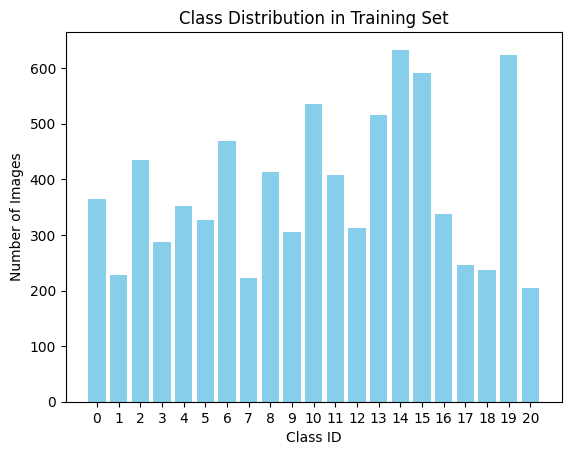

In [20]:
import os
import matplotlib.pyplot as plt

# Paths to the dataset directories
train_images_dir = 'model training data/images/train'  # Training images directory
train_labels_dir = 'model training data/labels/train'  # Training labels directory

# Initialize a dictionary to count the number of images for each class
class_counts = {}

# List all image files in the training set (accepting both .jpg, .JPG, and .png)
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.png'))]

# Loop through each image and count class occurrences based on the label file
for image_name in image_files:
    label_file = os.path.splitext(image_name)[0] + '.txt'  # Assuming label has the same name as image
    label_path = os.path.join(train_labels_dir, label_file)
    
    if os.path.exists(label_path):  # Ensure the label file exists
        with open(label_path, 'r') as f:
            labels = f.readlines()
        
        # Count the class IDs in the label file
        for label in labels:
            class_id = int(label.split()[0])  # Extract the class ID from the label
            if class_id not in class_counts:
                class_counts[class_id] = 0
            class_counts[class_id] += 1

# Data for the histogram plot
class_ids = list(class_counts.keys())
counts = list(class_counts.values())


plt.bar(class_ids, counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(class_ids)  # To ensure each class id has a corresponding tick
plt.show()


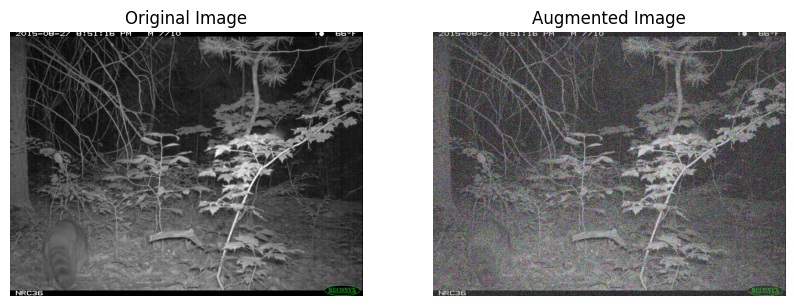

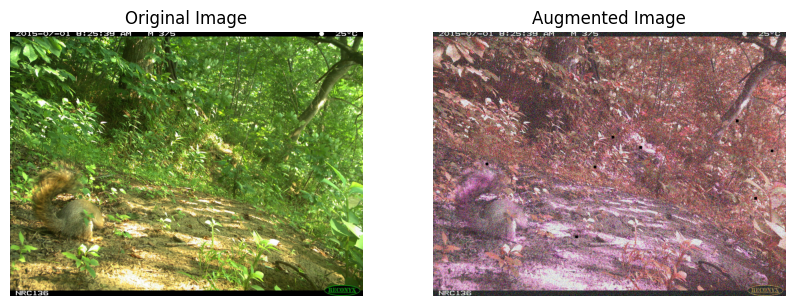

In [26]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(r'model training data\images\train\3881.jpg')
aug_image = cv2.imread(r'model training data\images\train\aug_3881.jpg')

# Convert RGB back to BGR 
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_bgr)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_image_bgr)
plt.title("Augmented Image")
plt.axis('off')

plt.show()
############################################
image = cv2.imread(r'model training data\images\train\588.jpg')
aug_image = cv2.imread(r'model training data\images\train\aug_588.jpg')

# Convert RGB back to BGR 
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_bgr)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_image_bgr)
plt.title("Augmented Image")
plt.axis('off')

plt.show()


# Train the model

In [29]:
from ultralytics import YOLO

model = YOLO('yolov8l.pt')

model.train(data='model training data/data.yaml', epochs=50, batch=16, imgsz=640)

AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)